In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

## COSC 757 Assignment 1
Working with the Algerian Forest Fires Dataset: https://archive.ics.uci.edu/ml/datasets/Algerian+Forest+Fires+Dataset++


In [10]:
#Split CSV into two datasets based on region
bejaia_df = pd.read_csv("bejaia_fire.csv",skiprows=1)
sidibel_df = pd.read_csv("sidibel_fire.csv",skiprows=1)

#Merge them into one dataset with an additional region column
bejaia_df['Region'] = 'Bejaia'
sidibel_df['Region'] = 'Sidi-Bel Abbes'

fire_df = pd.concat([bejaia_df,sidibel_df],ignore_index=True)
fire_df.columns = fire_df.columns.str.strip()
fire_df['Classes'] = fire_df['Classes'].str.strip()
fire_df = fire_df.astype({'DC':'float64','FWI':'float64','Classes':'category','Region':'category'})

In [4]:
fire_df.columns
#fire_df.columns

Index(['day', 'month', 'year', 'Temperature', 'RH', 'Ws', 'Rain', 'FFMC',
       'DMC', 'DC', 'ISI', 'BUI', 'FWI', 'Classes', 'Region'],
      dtype='object')

In [35]:
fire_df['Classes'].unique()


['not fire', 'fire']
Categories (2, object): ['fire', 'not fire']

['day' 'month' 'year' 'Temperature' 'RH' 'Ws' 'Rain' 'FFMC' 'DMC' 'DC'
 'ISI' 'BUI' 'FWI' 'Classes' 'Region']


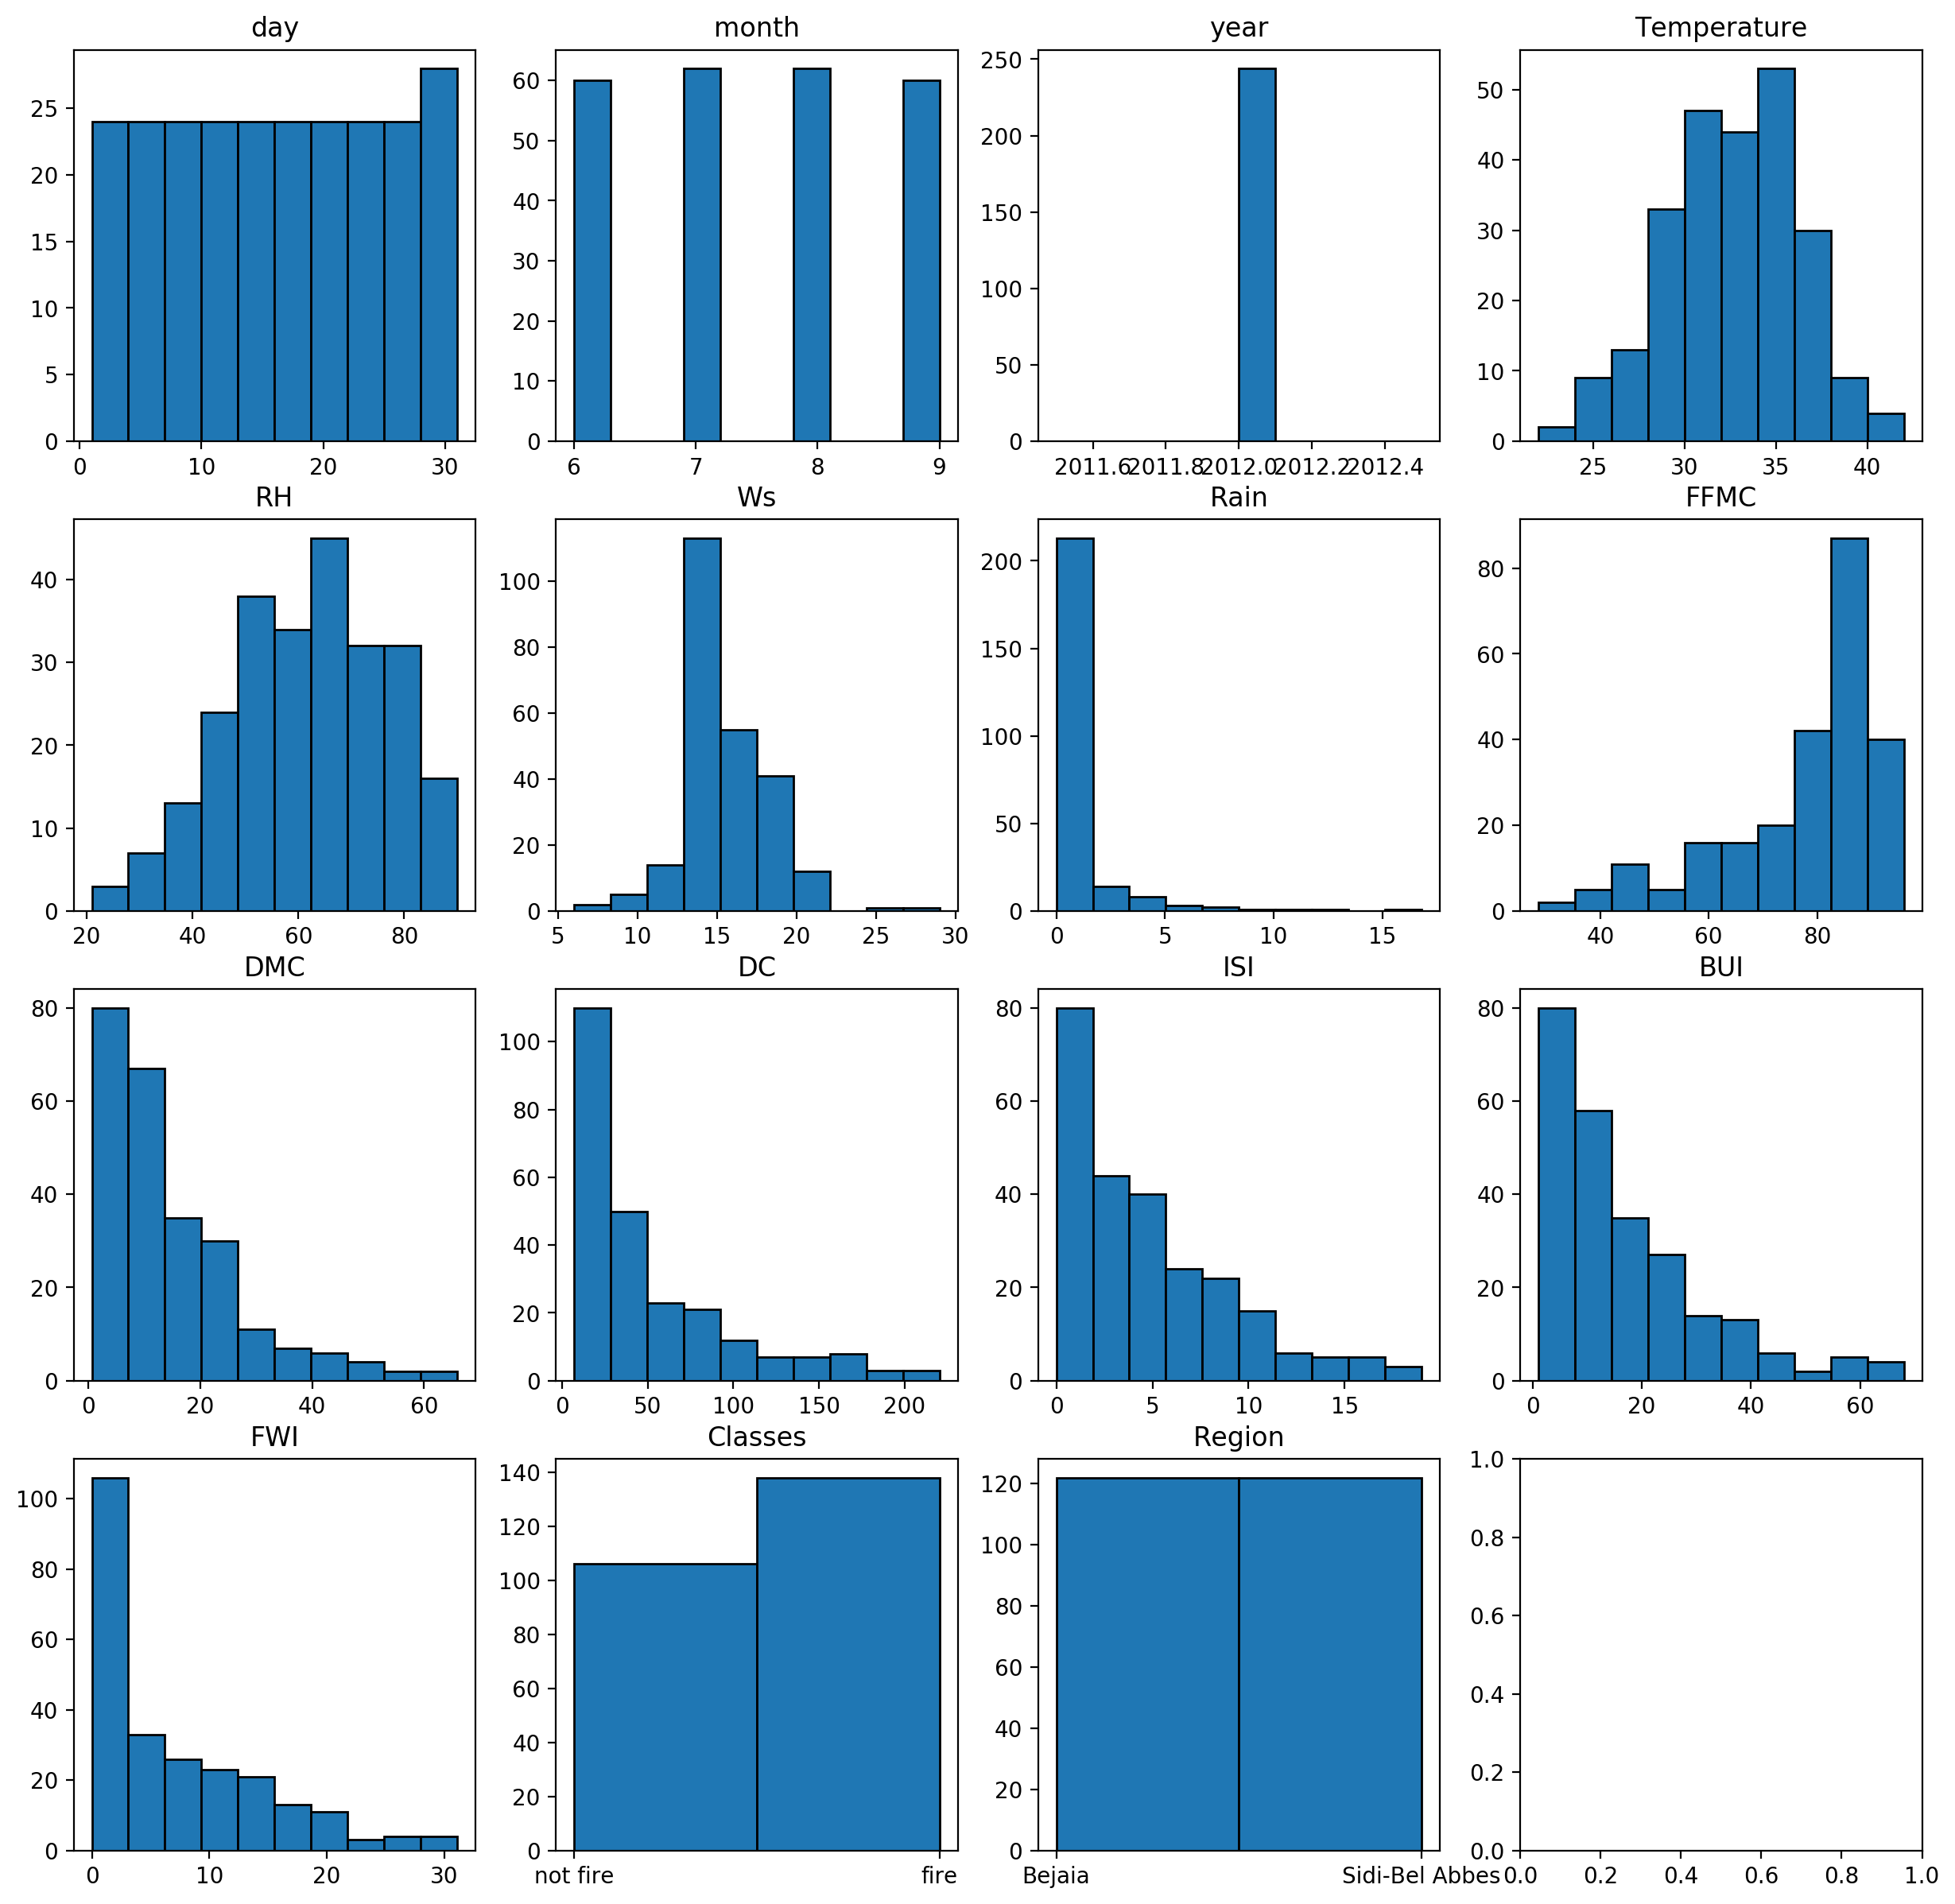

In [43]:
cols = np.array(fire_df.columns)
print(cols)

#np.array(fire_df[cols[0]])
count=0
fig, ax = plt.subplots(4,4,figsize=(15,15),dpi=200)
for i,col in enumerate(ax):
    for j, row in enumerate(col):
        try:
            feature = fire_df[cols[count]]
            
            feature_arr = np.array(feature)
            #print(feature_arr)
            ax[i,j].set_title(cols[count])
            if feature.dtype.name == 'category':
                ax[i,j].hist(feature_arr,bins=len(feature.unique()),ec='k')
            else:
                ax[i,j].hist(feature_arr,ec='k')
            count+=1
        except IndexError:
            pass

#print(type(fire_df['FWI'][240]))
#plt.hist(fire_df['Classes'],bins=2)


In [8]:
fire_df['Classes  '].unique()

KeyError: 'Classes  '